<h2>G2M insight for Cab Investment firm

In this document, analysis of data related to 2 companies activity from US Cab industry is provided. The goal is analyze market data and determine, which company is more attractive for investment.

First of all, we need to have a look at datasets presented. For this purposes we can use pandas to read csv files from the source.

In [2]:
import pandas as pd
import requests

cab_data_url = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Cab_Data.csv"
cab_data = pd.read_csv(cab_data_url)

city_url = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/City.csv"
city = pd.read_csv(city_url)

customer_id_url = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Customer_ID.csv"
customers = pd.read_csv(customer_id_url)

transaction_id_url = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Transaction_ID.csv"
transactions = pd.read_csv(transaction_id_url)

After reading the datasets we want to have a closer look at it. We can display a small piece of data. The first dataset describes key metrics of a ride - details of 2 companies transactions.

In [3]:
print(cab_data.shape)
cab_data.sample(3)

(359392, 7)


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
147211,10181432,42894,Pink Cab,BOSTON MA,32.48,294.64,383.2640
118938,10146068,42785,Yellow Cab,CHICAGO IL,20.58,368.98,256.8384
317555,10389728,43384,Yellow Cab,CHICAGO IL,30.51,467.86,395.4096


City dataset contents some US cities names, population of the cities and number of Cab users in each city. We suggest that users metric includes users of Pink Cab and Yellow Cab.

In [4]:
print(city.shape)
city.sample(3)

(20, 3)


,City,Population,Users
1,CHICAGO IL,"1,955,130","164,468"
16,PITTSBURGH PA,"542,085","3,643"
17,WASHINGTON DC,"418,859","127,001"


Customers dataset contains information about customer detailes - gender, age, income per month.

In [5]:
print(customers.shape)
customers.sample(3)

(49171, 4)


,Customer ID,Gender,Age,Income (USD/Month)
25147,35142,Female,37,17006
38680,20224,Male,41,24753
15907,51691,Male,30,3754


Transactions dataset contains information about payment mode used by a certain customer during a certain trip.

In [6]:
print(transactions.shape)
transactions.sample(3)

(440098, 3)


,Transaction ID,Customer ID,Payment_Mode
242037,10242048,37851,Card
206542,10206553,59022,Cash
76426,10076437,59700,Card


Both cab_data and transactions data have Transaction ID column but transaction data has more rows than cab data. We can suggest that either there are duplicates in transaction dataset or there are transactions in transaction dataset which are not present in cab data. We can check it.

In [7]:
#check for duplicates
bool_series = transactions.duplicated()
print(f'Number of duplicates in transaction dataset - {bool_series[bool_series == True].count()}')

#find transactions that are not in cab_data
ser1 = transactions['Transaction ID'] 
ser2 = cab_data['Transaction ID']
print(f'Number of transactions which are absent in cab_data - {ser1[~ser1.isin(ser2)].count()}')

Number of duplicates in transaction dataset - 0
Number of transactions which are absent in cab_data - 80706


We can see that the dataframes have some common columns and we can join the dataframes into one. E.g., cab_data has transaction_id and city columns. City and transactions datasets have the same columns. Also, transactions and customers datasets have a common column customer ID. So, we can merge these datasets and create a new one.

In [8]:
#merging datasets
df1 = pd.merge(cab_data, city)
df2 = pd.merge(df1, transactions)
df = pd.merge(df2, customers)

We can consider transaction ID here as an unique identifier or primary key. Merging cab_data and transactions we can see that not all examples from transaction dataset are in cab_data dataset. We use inner join, so, part of transactions dataset won't be used. Relation between datasets - one to one. On the other hand, several transactions can be related to one city or one client. Relation between cab_data and these two datasets - one to many, since one of the two key columns contains duplicate entries.  

In [9]:
#checking created dataset for duplicates
bool_series = df.duplicated()
print(f'Number of duplicates in merged dataset - {bool_series[bool_series == True].count()}')


Number of duplicates in merged dataset - 0


We can have repeated values in some columns (e.g. cities) but now we consider it in comparison with other columns. So, there are no full duplicates in the dataset.

Creating an united dataset, we can a move to more detailed analysis of the data. Below there is information about columns data types and number of null values in each column. We can see that there are no null values in columns and some columns have inappropriate data type:
- Date of Travel - needed to convert to datetime object
- Population - needed to convert to int64
- Users - needed to convert to int64

In [10]:
#brief info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction ID      359392 non-null  int64  
 1   Date of Travel      359392 non-null  int64  
 2   Company             359392 non-null  object 
 3   City                359392 non-null  object 
 4   KM Travelled        359392 non-null  float64
 5   Price Charged       359392 non-null  float64
 6   Cost of Trip        359392 non-null  float64
 7   Population          359392 non-null  object 
 8   Users               359392 non-null  object 
 9   Customer ID         359392 non-null  int64  
 10  Payment_Mode        359392 non-null  object 
 11  Gender              359392 non-null  object 
 12  Age                 359392 non-null  int64  
 13  Income (USD/Month)  359392 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 41.1+ MB


Let's change these columns dtype by applying functions to them. Also it could be better to transform df columns names for more convenient use.

In [11]:
#transform columns names for more convenient use
def heading(string):
    return string.lower().replace(' ', '_')
df.columns = [heading(i) for i in df. columns]

#function that converts objects to integers
def convert_to_int(string):
    if ',' in string:
        return int(string.replace(',',''))
    return int(string)

#transform date column (convert excel serial date to datetime object)
def convert_date(string):
    import xlrd
    datetime_date = xlrd.xldate_as_datetime(int(string), 0)
    #date_object = datetime_date.date()
    return datetime_date

#apply function - convert date of travel to datetime object
df.date_of_travel = df.date_of_travel.apply(convert_date)

#aplly function - convert population and users values to integer
df.population = df.population.apply(convert_to_int)
df.users = df.users.apply(convert_to_int)

#check that dtypes are changed
df[['date_of_travel', 'population', 'users']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date_of_travel  359392 non-null  datetime64[ns]
 1   population      359392 non-null  int64         
 2   users           359392 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 11.0 MB


Also we can see that in city column cities are displayed with a state code. We can separate states from cities.

In [12]:
#display unique values of cities
print(list(df.city.unique()))

#we can see that ORANGE COUNTY AND SILICON VALLEY don't have a state code but we know that they are situated in California. So, we can incluse them to CA group.
#function to extract state code
def extract_state(string): 
    if ' ' in string and string != 'ORANGE COUNTY' and string != 'SILICON VALLEY':
      splitted = string.split(' ')
      return splitted[-1]
    return None

#function to extract city
def extract_city(string):
  if ' ' in string:
    if string == 'ORANGE COUNTY' and string != 'SILICON VALLEY':
        return string
    splitted = string.split(' ')
    return ' '.join(splitted[:-1])

#apply functions
df['state'] = df.city.apply(extract_state)
df['city'] = df.city.apply(extract_city)

#fill null values with CA state
df.state = df.state.fillna('CA')

#check that all the values are filled
df[['city', 'state']].info()

['ATLANTA GA', 'AUSTIN TX', 'BOSTON MA', 'CHICAGO IL', 'DALLAS TX', 'DENVER CO', 'LOS ANGELES CA', 'MIAMI FL', 'NASHVILLE TN', 'NEW YORK NY', 'ORANGE COUNTY', 'PHOENIX AZ', 'PITTSBURGH PA', 'SACRAMENTO CA', 'SAN DIEGO CA', 'SEATTLE WA', 'SILICON VALLEY', 'TUCSON AZ', 'WASHINGTON DC']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   city    359392 non-null  object
 1   state   359392 non-null  object
dtypes: object(2)
memory usage: 8.2+ MB


Next step is to detect and remove outliers. We can apply this technique only to numeric features. We have 9 numeric features. Let's create whisker plots and histogramms of the numeric features. Also, we'd like to look at summary statistics.

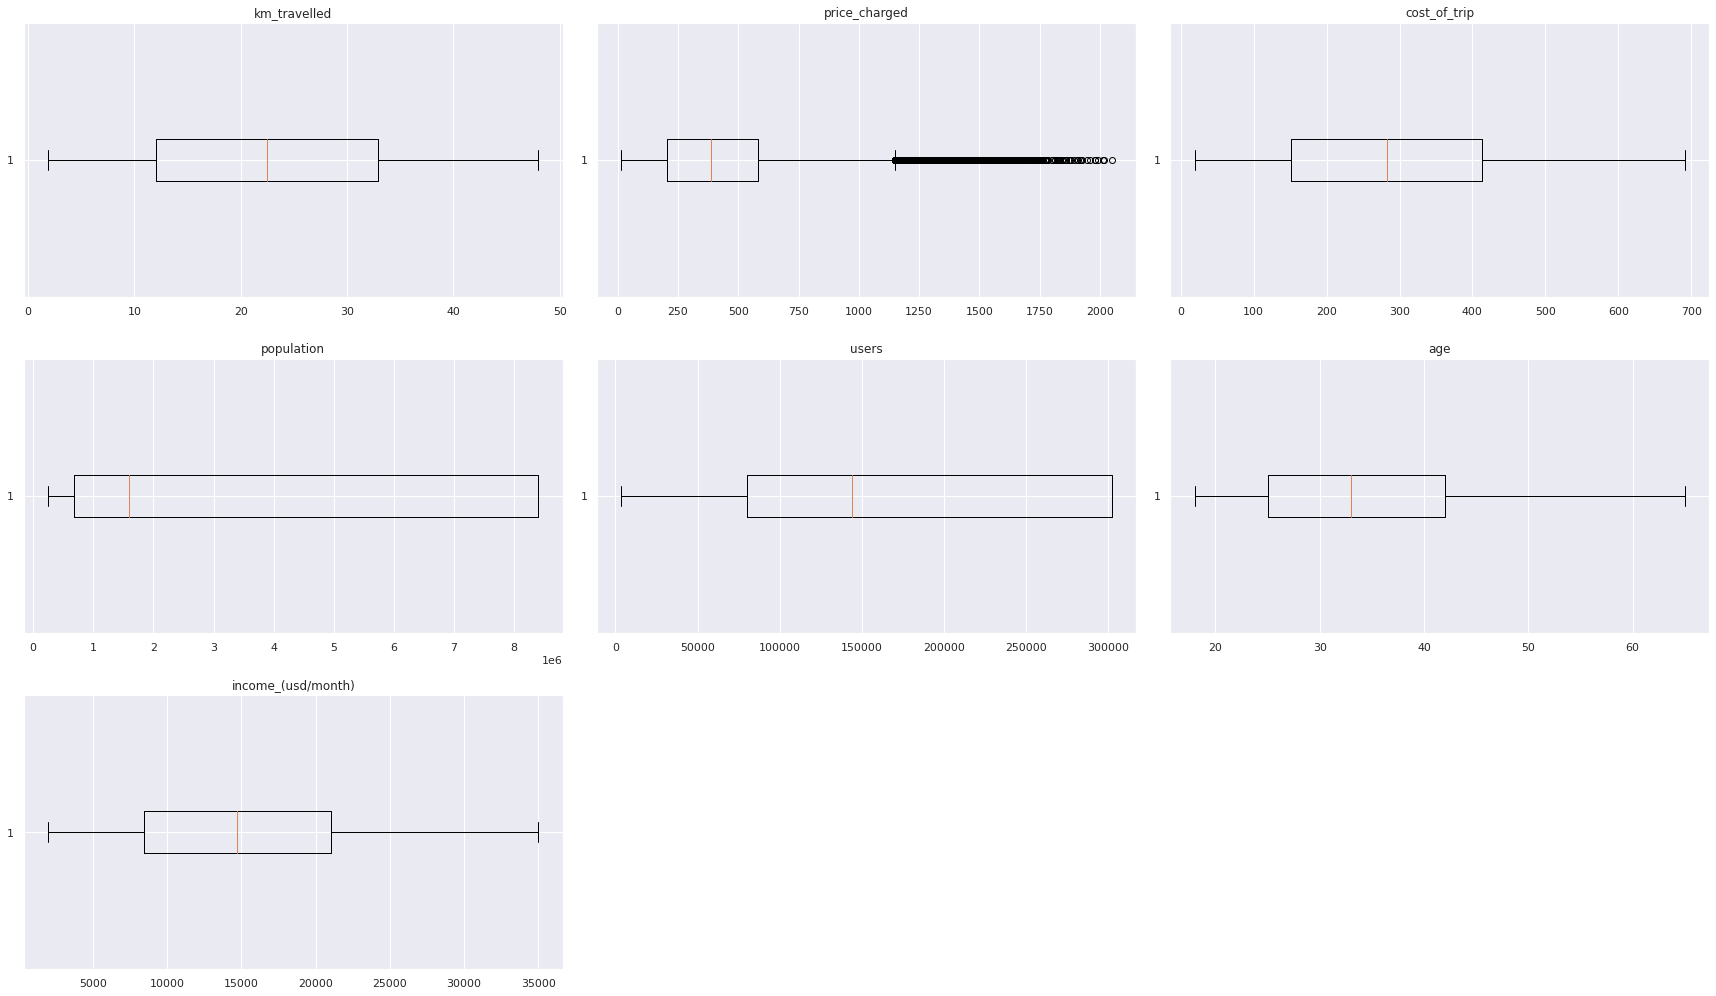

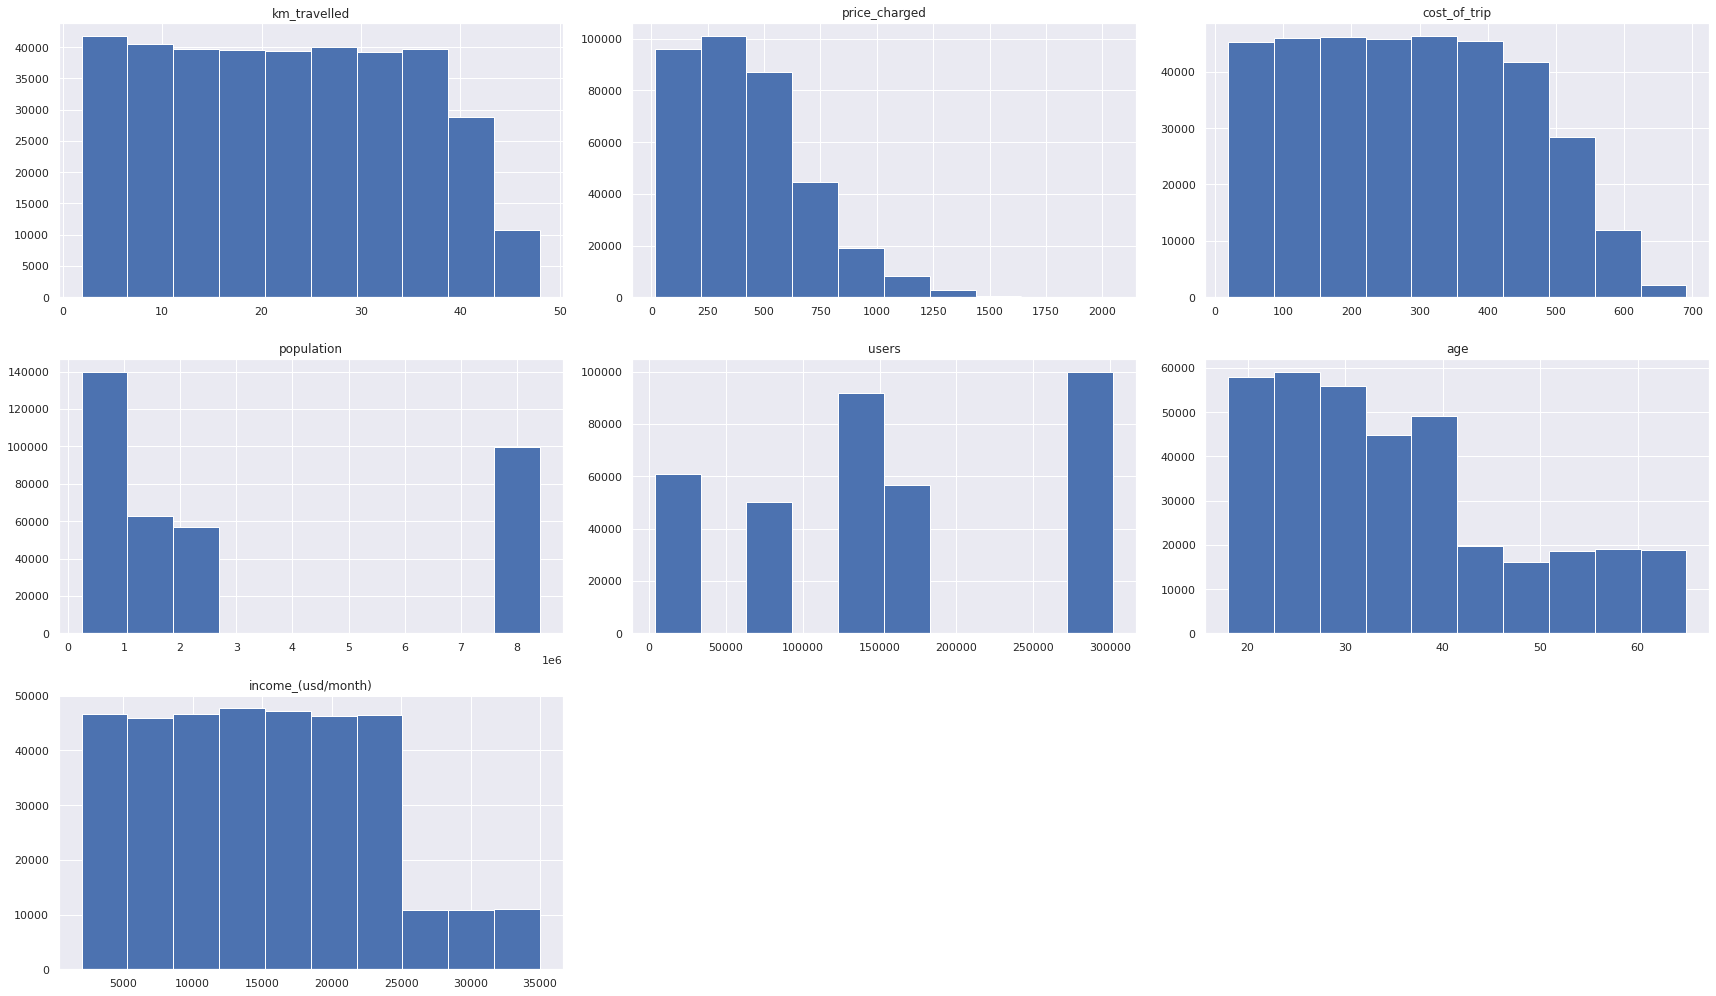

,km_travelled,price_charged,cost_of_trip,population,users,age,income_(usd/month)
count,359392.00,359392.00,359392.00,359392.00,359392.00,359392.00,359392.00
mean,22.57,423.44,286.19,3132198.04,158365.58,35.34,15048.82
std,12.23,274.38,157.99,3315194.39,100850.05,12.59,7969.41
min,1.90,15.60,19.00,248968.00,3643.00,18.00,2000.00
25%,12.00,206.44,151.20,671238.00,80021.00,25.00,8424.00
50%,22.44,386.36,282.48,1595037.00,144132.00,33.00,14685.00
75%,32.96,583.66,413.68,8405837.00,302149.00,42.00,21035.00
max,48.00,2048.03,691.20,8405837.00,302149.00,65.00,35000.00


In [49]:
#Graphs for outlier detection
#list of columns with numeric values. We don't include transaction and customer id, since id value doaesn't bring additional informarion.
columns = ['km_travelled',
 'price_charged',
 'cost_of_trip',
 'population',
 'users',
 'age',
 'income_(usd/month)']

#create list of df columns 
cols_df = [df[i] for i in columns]

import matplotlib
import matplotlib.pyplot as plt

#draw boxplot or whisker plot
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.boxplot(i, vert = 0)
    ax.title.set_text(title)
fig.delaxes(axs[2,2])
fig.delaxes(axs[2,1])
fig.tight_layout()
plt.show()

#draw histogram to show distribution
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.hist(i)
    ax.title.set_text(title)
fig.delaxes(axs[2,2])
fig.delaxes(axs[2,1])
fig.tight_layout()
plt.show()

#show summary statistics
round(df[columns].describe(),2)

Most of the features have symmetric or right-skewed distribution. We can see that no features have outliers, except price_charged parameter. The outliers are concentrated above a maximum border. We can check price per km to understand the nature of outliers. We create separate pd series, calculate price per km by dividing price_charged to km_traveled. We can see that the outliers still exist. Hovewer, price factor is determined not only by distance travelled but also by time spended, including downtime in traffic jams. Since we don't have information about time of a trip, it could be more reasonable to keep these examples to save the full picture of the market.

Also, we can see that features km_travelled, cost_of_trip, age and income distributions have a tendency to decline at maximum values. Based on the graphs, we cannot say that the disributions look like normal ones because the form is not a bell. Population and users have quite significant spaces in distribution, it could be due to small number of cities in the sample.

We can see that in average, passenger age is 35, passenger income is about 15000, distance is 22,6 km , price per trip is 423.44, cost is 286.19. Later we'll examine these values by companies.

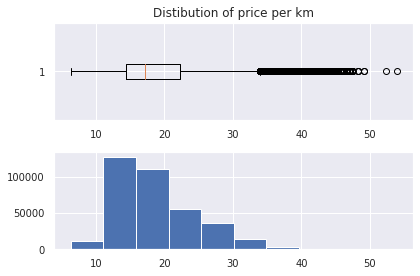

In [50]:
#add new column to df - price per km and plot it's distribution
df['price_per_km'] = df.price_charged.div(df.km_travelled, axis=0)

fig, axs = plt.subplots(2)
axs[0].boxplot(df.price_per_km, vert = 0)
axs[1].hist(df.price_per_km)
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=10)
axs[0].set_title('Distibution of price per km') 
plt.tight_layout()
plt.show() 


As we can see, price per km also has outliers. Next step is to reveal correlations between numeric features. For these purposes I create correlation table and heatmap. 

,km_travelled,price_charged,cost_of_trip,population,users,age,income_(usd/month)
km_travelled,1.00,0.84,0.98,-0.00,-0.00,-0.00,-0.00
price_charged,0.84,1.00,0.86,0.33,0.28,-0.00,0.00
cost_of_trip,0.98,0.86,1.00,0.02,0.02,-0.00,-0.00
population,-0.00,0.33,0.02,1.00,0.92,-0.01,0.01
users,-0.00,0.28,0.02,0.92,1.00,-0.01,0.01
age,-0.00,-0.00,-0.00,-0.01,-0.01,1.00,0.00
income_(usd/month),-0.00,0.00,-0.00,0.01,0.01,0.00,1.00


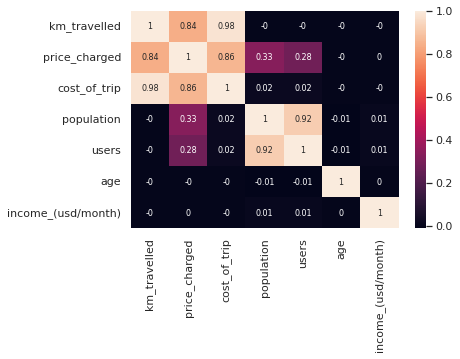

In [15]:
import seaborn as sns
#set font size
sns.set(font_scale=1)

#create correlation matrix
df_corr = df[columns].corr()
df_corr = df_corr.round(2)

#create correlation heatmap
sns.heatmap(df_corr, annot=True, annot_kws={"size": 8})

#display correlation matrix
df_corr

We can see that there are some interesting connections that could be revealed. First, consider the features with the highest correlation coefficients. These are km_travelled, price_charged and cost_of_trip. It's quite predictable that these parameters are strongly connected. Longer trips have higher price and cost. We can add profit and profit per km features to the dataset since these features are more informative.
Profit of trip is calculated as price - cost of trip.
Profit_per_km is calculated as (price - cost of trip)/km.

Correlation between population abd number of users is significant. More populated cities have more cab users.

Also, there is quite high correlations between price_per_km and population and users features and it's positive. So, more populated cities with more cab users have higher price_per_km and also price_charged in general.

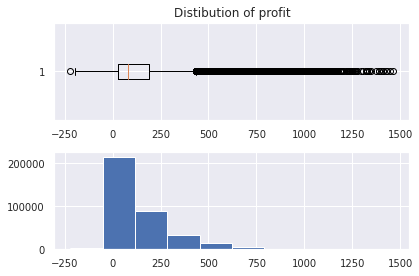

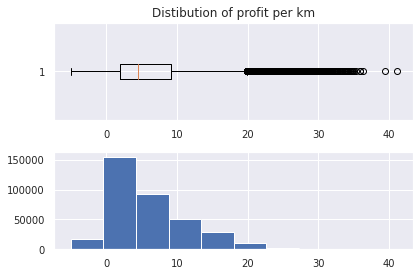

In [16]:
#add new columns 
df['profit'] = df.price_charged - df.cost_of_trip
df['profit_per_km'] = df.profit.div(df.km_travelled, axis=0)

#display the distribution
fig, axs = plt.subplots(2)
axs[0].boxplot(df.profit, vert = 0)
axs[1].hist(df.profit)

for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=10)
axs[0].set_title('Distibution of profit') 
plt.tight_layout()
plt.show() 

fig, axs = plt.subplots(2)
axs[0].boxplot(df.profit_per_km, vert = 0)
axs[1].hist(df.profit_per_km)

for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=10)
axs[0].set_title('Distibution of profit per km') 
plt.tight_layout()
plt.show() 

Also, there are categorical values in the dataset: company, gender, city, payment mode. We can display statistics to look at a number of classes of each feature.

In [17]:
#create list of columns
categorical = list(df.select_dtypes(include=['object']).columns)
#create table
df[categorical].nunique()

company          2
city            19
payment_mode     2
gender           2
state           13
dtype: int64

After initial data treatment we can dive into more detailed analysis of business problem.

A business problem is to choose a better company for investment. It's important for any Cab company to maximize  profit, especially profit per km cause each additional km is connected with additional costs (fuel, amortization, etc.). It's also important to increase number of customers, particularly number of loyal customers, increase presence in all income, age and gender groups and also expand geographically. Also it's important to maintain good results for longtime. The choice of a company to invest in should be taken based on the companies performance.

I consider this dataset from several perspectives:
- analysis of key metrics in time (profit and number of customers dynamics);
- customer profile(gender, age, income, payment mode analysis);
- regional analysis(how location affects companies efficiency).
I will consider these factors for 2 companies in comparison.

First of all, we can explore the dataframe structure by companies. We can see that the number of transactions in Yellow Cab more than 3 times exceeds the number of transactions in Pink Cab for the period given. It's worth to mention that the dataset containes only successful transactions, e.g. we don't have information about a number of suspended trips.

In [18]:
pink = df[df.company == 'Pink Cab']
yellow = df[df.company == 'Yellow Cab']

print(f"Number of transactions in Pink Cab - {pink.shape[0]}")
print(f"Number of transactions in Yellow Cab - {yellow.shape[0]}")


Number of transactions in Pink Cab - 84711
Number of transactions in Yellow Cab - 274681


Also, we can look at summary statistic by companies.

In [19]:
comp_stat = df.groupby('company')[columns].mean().reset_index()
transp = comp_stat.transpose()
new_header = transp.iloc[0] #grab the first row for the header
transp = transp[1:] #take the data less the header row
transp.columns = new_header #set the header row as the df header
transp

company,Pink Cab,Yellow Cab
km_travelled,22.559917,22.569517
price_charged,310.800856,458.18199
cost_of_trip,248.148682,297.922004
population,2350641.508317,3373228.314532
users,125590.81333,168473.246981
age,35.322414,35.341112
income_(usd/month),15059.047137,15045.669817


We can see that Yellow Cab in average has higher price and cost of trip. However, the difference between mean costs of trip is less than difference in prices, that's why difference in profit and profit per km is significant. Also, in average Yellow Cab works in more populated cities with bigger number of cab service users.Mean distance of trip, age and income of customers are the same but we could need aditional check of it. 

We will start from key operational activity metrics in dynamic and related hypothesis. First, we can look at number of transactions and number of customers in dynamic and plot it by months. It's needed to create additional columns related to time intervals.

Hypothesis1 - there is seasonality in companies performance (number of transactions, number of customers, profit, profit per km).

Hypothesis2 - there is significant difference in mean values of companies performance (number of transactions, number of customers, profit, profit per km). Concretely, mean of Yellow Cab is bigger.

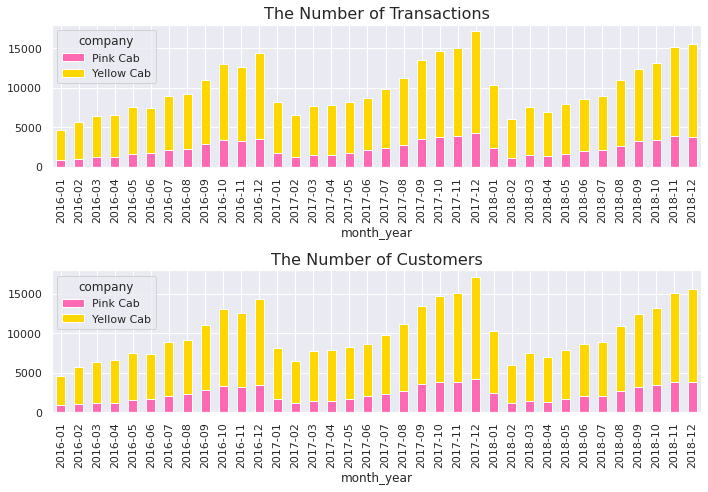

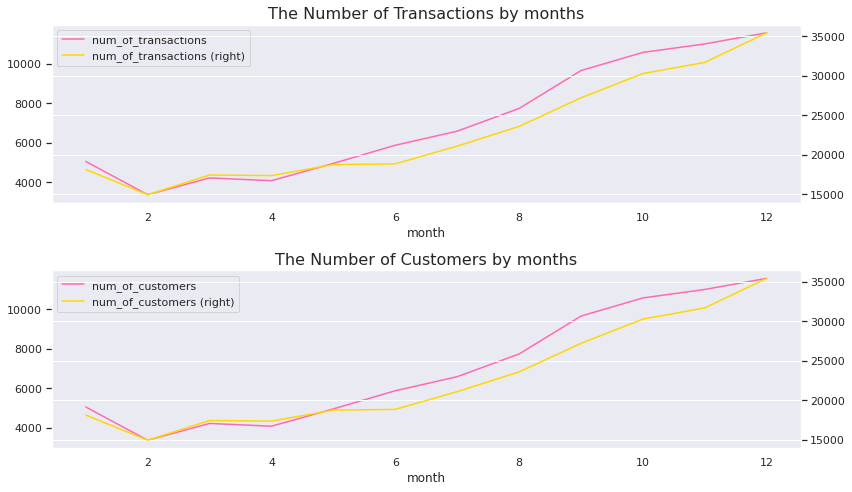

In [20]:
#create additional columns of datetime type
df['year'] = pd.DatetimeIndex(df['date_of_travel']).year
df['month'] = pd.DatetimeIndex(df['date_of_travel']).month
df['month_year'] = pd.to_datetime(df['date_of_travel']).dt.to_period('M')

#create df
df_trans_month = df.groupby(['company', 'month_year', 'month']).agg({'transaction_id' : 'count'}).reset_index()
df_cust_month = df.groupby(['company', 'month_year', 'month']).agg({'customer_id' : 'count'}).reset_index()

#change df columns names
df_trans_month.columns = ['company', 'month_year', 'month', 'num_of_transactions']
df_cust_month.columns = ['company', 'month_year', 'month', 'num_of_customers']

#create pivot tables
pivot1 = pd.pivot_table(data=df_trans_month, index=['month_year'], columns=['company'], values=['num_of_transactions'])
pivot2 = pd.pivot_table(data=df_cust_month, index=['month_year'], columns=['company'], values=['num_of_customers'])

#plot transactions and customers number dynamic
fig, ax = plt.subplots(2)
pivot1.plot(ax = ax[0], y='num_of_transactions', kind = 'bar', color=['hotpink','gold'], stacked = True, figsize = (10,7))
pivot2.plot(ax = ax[1], y='num_of_customers', kind = 'bar', color=['hotpink','gold'], stacked = True, figsize = (10,7))

ax[0].set_title('The Number of Transactions', fontsize=16)
ax[1].set_title('The Number of Customers', fontsize=16)
plt.tight_layout()

#plot transactions and customers number dynamic during a year 
fig, ax = plt.subplots(2)
df_trans_month[df_trans_month.company == 'Pink Cab'].groupby('month').agg({'num_of_transactions': 'sum'}).plot(ax = ax[0], figsize = (12,7), color = 'hotpink')
df_trans_month[df_trans_month.company == 'Yellow Cab'].groupby('month').agg({'num_of_transactions': 'sum'}).plot(ax = ax[0], figsize = (12,7), secondary_y = True, color = 'gold')

df_cust_month[df_cust_month.company == 'Pink Cab'].groupby('month').agg({'num_of_customers': 'sum'}).plot(ax = ax[1], figsize = (12,7), color = 'hotpink')
df_cust_month[df_cust_month.company == 'Yellow Cab'].groupby('month').agg({'num_of_customers': 'sum'}).plot(ax = ax[1], figsize = (12,7), secondary_y = True, color = 'gold')
ax[0].set_title('The Number of Transactions by months', fontsize=16)
ax[1].set_title('The Number of Customers by months', fontsize=16)
#ax[0].legend(labels = ['Pink Cab', 'Yellow Cab'])
#ax[1].legend(labels = ['Pink Cab', 'Yellow Cab'])
plt.tight_layout();

We can see that both companies have similar dynamic of transactions and customers number during a year but Yellow Cab has more significant numbers. Minimal number is ib February, after that it starts to grow and achieve maximum by December and drops in January again. Maximum number of transactions and customers was in December 2017. We would like to examine the same with regard to profit. But before,let's also look at customers number in shares.

,company,customer_id,percent_of_customers
0,Pink Cab,84711,23.570642
1,Yellow Cab,274681,76.429358


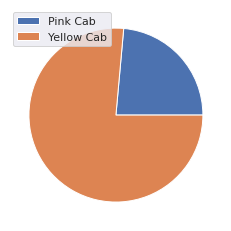

In [48]:
df_cust = df.groupby('company').agg({'customer_id':'count'}).reset_index()
df_cust['percent_of_customers'] = df_cust.customer_id/df_cust.customer_id.sum() * 100

plt.pie(df_cust['percent_of_customers']) 
plt.legend(['Pink Cab', 'Yellow Cab']) 
df_cust

 In general, Yellow Cab has more than 76% of customer base. Move to dynamic analysis of profit.

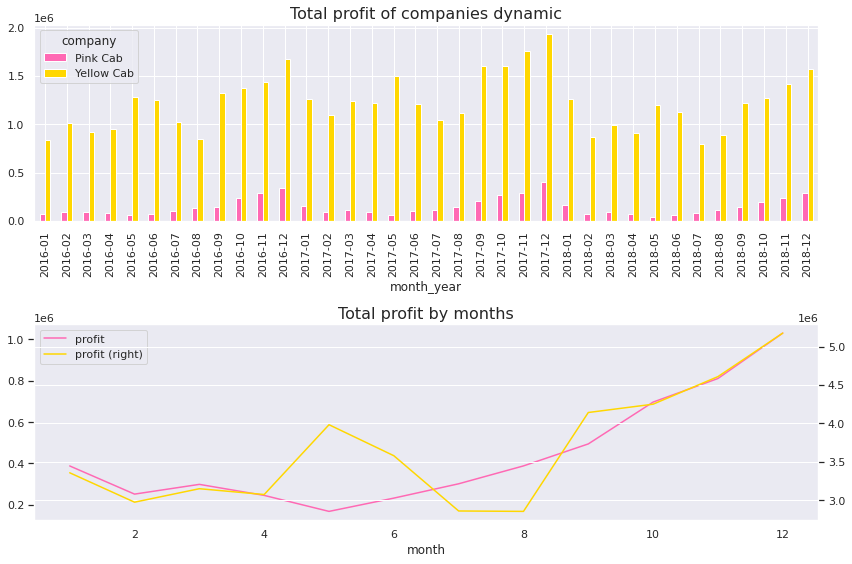

In [22]:
#create dataframe
df_profit_month = df.groupby(['company', 'month_year', 'month']).agg({'profit' : 'sum'}).reset_index()

#create pivot
pivot = pd.pivot_table(data=df_profit_month, index=['month_year'], columns=['company'], values=['profit'])

fig, ax = plt.subplots(2)
pivot.plot(ax = ax[0], y='profit', kind = 'bar', color=['hotpink','gold'], stacked = False, figsize = (12,8))
df_profit_month[df_profit_month.company == 'Pink Cab'].groupby('month').agg({'profit': 'sum'}).plot(ax = ax[1], color = 'hotpink')
df_profit_month[df_profit_month.company == 'Yellow Cab'].groupby('month').agg({'profit': 'sum'}).plot(ax = ax[1], secondary_y = True, color = 'gold')

ax[0].set_title('Total profit of companies dynamic', fontsize=16)
ax[1].set_title('Total profit by months', fontsize=16)
plt.tight_layout();

We can see that there are fluctuations of the total profit and it has similar dynamic by months. There are differences in fluctuations between 2 companies. Yellow Cab has high profit in May, while Pink Cab has the minimum in this month. On the contrary, in July and August Yellow Cab has minimum profit but Pink Cab's profit countinues to grow. Let's examine the profit per km in a similar way. 

,profit_per_km
company,
Pink Cab,2.702785
Yellow Cab,7.367265


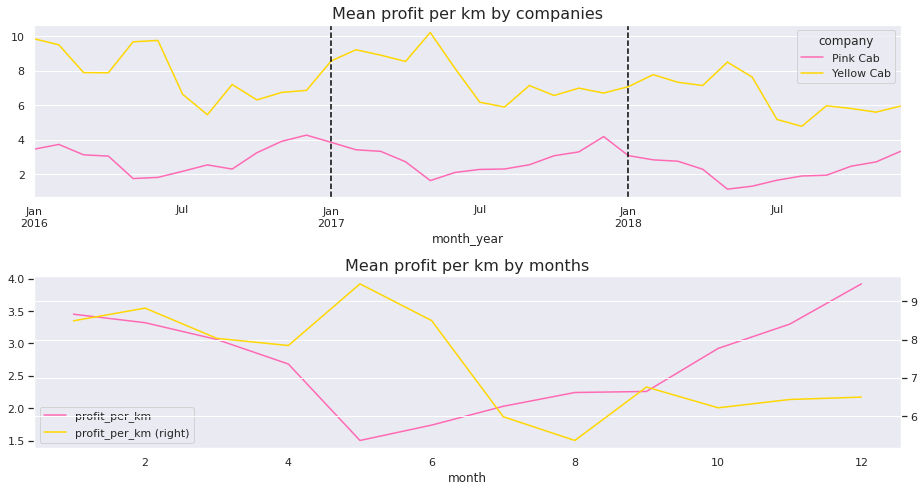

In [23]:
df_profitkm_month = df.groupby(['company', 'month_year', 'month']).agg({'profit_per_km' : 'mean'}).reset_index()
#print(f"Mean profit per km of Yellow Cab {round(pivot['Yellow Cab'].div(pivot['Pink Cab']).mean(), 2)} times exceeds profit per km of Pink Cab") 
pivot = pd.pivot_table(data=df_profitkm_month, index=['month_year'], columns=['company'], values='profit_per_km')

fig, ax = plt.subplots(2)
pivot.plot.line(ax = ax[0], color=['hotpink','gold'],figsize = (13,7)) 
df_profitkm_month[df_profitkm_month.company == 'Pink Cab'].groupby('month').agg({'profit_per_km': 'mean'}).plot(ax = ax[1], color = 'hotpink')
df_profitkm_month[df_profitkm_month.company == 'Yellow Cab'].groupby('month').agg({'profit_per_km': 'mean'}).plot(ax = ax[1], secondary_y = True, color = 'gold')

ax[0].set_title('Mean profit per km by companies', fontsize=16)
ax[1].set_title('Mean profit per km by months', fontsize=16)
xcoords = ['2016-01-01','2017-01-01', '2018-01-01']
for xc in xcoords:
   ax[0].axvline(x=xc, color='black', linestyle='--')
plt.tight_layout() 
df_profitkm_month.groupby('company').agg({'profit_per_km': 'mean'})

We can also consider the features by days of week to identify the trend. We can see that demand increases in second half of the week. Profit per km increases smoothly, the most profitavble trips are on Sundays. Maximum number of trips are on Fridays and it remains high on weekends. Again, we can see that Yellow Cab outperforms its competitive in these metrics.

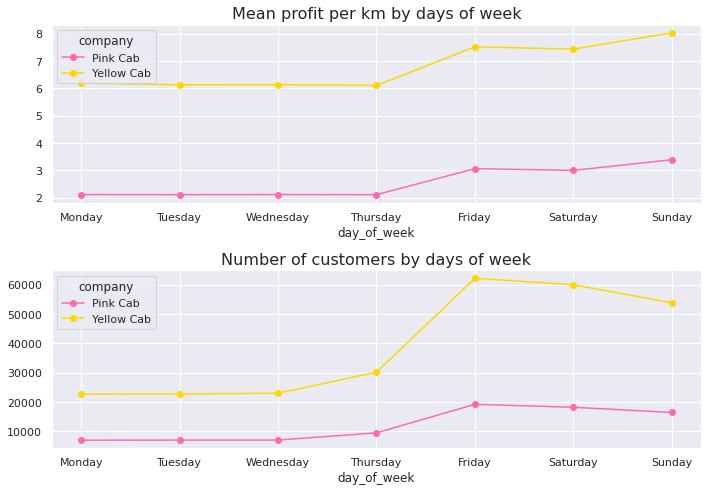

In [24]:
#create df column
df['day_of_week'] = df['date_of_travel'].dt.day_name()
dayofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=dayofweek, ordered=True)

#create dataframe and pivot table
df_dayofw = df.groupby(['company', 'day_of_week']).agg({'customer_id': 'count', 'profit_per_km' : 'mean'})
pivot = pd.pivot_table(data=df_dayofw, index=['day_of_week'], columns=['company'], values=['profit_per_km', 'customer_id'])

#plot 
fig, ax = plt.subplots(2)
pivot.plot(kind = 'line', ax = ax[0], y = 'profit_per_km', color=['hotpink','gold'],figsize = (10,7), marker = 'o') 
pivot.plot(kind = 'line', ax = ax[1], y = 'customer_id', color=['hotpink','gold'],figsize = (10,7), marker = 'o') 

ax[0].set_title('Mean profit per km by days of week', fontsize=16)
ax[1].set_title('Number of customers by days of week', fontsize=16)

#remane transaction_id in all cases
df_dayofw.groupby('company').agg({'customer_id': 'sum', 'profit_per_km' : 'mean'})
plt.tight_layout() 

We can see that in average mean profit per km of Yellow Cab is 3 times higher than profit per km of Pink Cab. The dynamic by months looks similar to dynamic of total profit. However, at the begining of the year profit per km is relatively high and we can conclude that low total profit in 1st quarter of the year is connected with small number of rides. On the contrary, especially for Yellow Cab, at the end of the year mean profit is relatively low but the company compensates it by high number of rides. We can check correlation between customer number, profit and profit per km to see the relations in numerical form. We will use date_of_travel column for more observations.

In [25]:
df_corr = df.groupby(['date_of_travel']).agg({'customer_id' : 'count', 'profit_per_km' : 'mean', 'profit': 'sum'}).reset_index()
corr_prof_km_trans = df_corr[['customer_id', 'profit_per_km', 'profit']].corr()
corr_prof_km_trans

,customer_id,profit_per_km,profit
customer_id,1.000000,0.164564,0.937653
profit_per_km,0.164564,1.000000,0.454887
profit,0.937653,0.454887,1.000000


We can see that correlation between number of customers and total profit is very strong. Correlation between number of customers and profit per km is much less.

After that, we would like to explore customer retention and learn, how mahy customers used Cab service more than 5 times and more than 10 times in the companies.

Hypothesis3 - Yellow Cab has higher customer retention (calculated as number of customers who used the service more than 5 times).

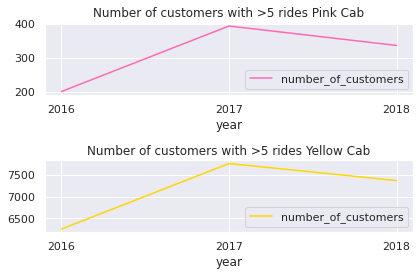

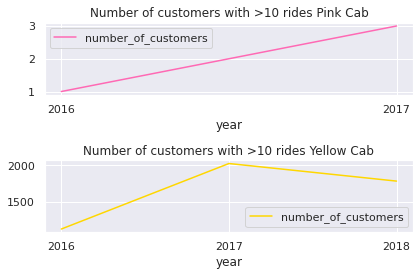

In [26]:
df_customers_trans = df.groupby(['company', 'customer_id', 'year']).agg({'transaction_id':'count'})
df_customers_trans_5 = df_customers_trans[df_customers_trans.transaction_id >= 5].reset_index()
df_customers_trans_55 = df_customers_trans_5.groupby(['company', 'year']).agg({'customer_id': 'count'}).reset_index(level = 0)
df_customers_trans_55.columns = ['company', 'number_of_customers']
fig, ax = plt.subplots(2)
plt.setp(ax, xticks=[2016, 2017, 2018], xticklabels=['2016', '2017', '2018'])
df_customers_trans_55[df_customers_trans_55.company == 'Pink Cab'].plot(ax = ax[0], color = 'hotpink')
df_customers_trans_55[df_customers_trans_55.company == 'Yellow Cab'].plot(ax = ax[1], color = 'gold');
ax[0].set_title('Number of customers with >5 rides Pink Cab', fontsize=12)
ax[1].set_title('Number of customers with >5 rides Yellow Cab', fontsize=12)
plt.tight_layout() 
 
df_customers_trans_10 = df_customers_trans[df_customers_trans.transaction_id >= 10].reset_index()
df_customers_trans_101 = df_customers_trans_10.groupby(['company', 'year']).agg({'customer_id': 'count'}).reset_index(level = 0)
df_customers_trans_101.columns = ['company', 'number_of_customers']
fig, ax = plt.subplots(2)
plt.setp(ax, xticks=[2016, 2017, 2018], xticklabels=['2016', '2017', '2018'])
df_customers_trans_101[df_customers_trans_101.company == 'Pink Cab'].plot(ax = ax[0], color = 'hotpink')
df_customers_trans_101[df_customers_trans_101.company == 'Yellow Cab'].plot(ax = ax[1], color = 'gold');
ax[0].set_title('Number of customers with >10 rides Pink Cab', fontsize=12)
ax[1].set_title('Number of customers with >10 rides Yellow Cab', fontsize=12)
plt.tight_layout() 

We can see that Yellow Cab has higher customer retention cause it has bigger number of customers with several trips. In general, number of loyal customers increased from 2016 to 2017, in 2018 it decreased. Also, Pink Cab didn't have customers with more than 10 rides per year in 2018.

Next, we would like to build forecasts for 2019 year. It could be interesting to know what is further dynamic of companies number of customers, profit and mean profit per km and what's the trend. 

After having a look on key metrics and its dynamic we can analyze customers.

Customer profile analysis include:
-gender analysis;
-age analysis;
-income analysis;
-payment method analysis.

Hypothesis4 - in average number of customers - women is less than number of customers-men and contribution to the company profit is also inequal, mean profit per km is less for customers-women.

Hypothesis5 - in average elder people use Cab service less frequently and contribution of this age segment to total profit is less.

Hypothesis6 - in average people with higher income use Cab service more often and contribution of this age segment to total profit is more.

Hypothesis7 - in average people use payment by cash less often.

Let's analyze how the gender affects customers number and profit.

customer_id            profit           profit_per_km     
gender          Female    Male    Female      Male        Female Male
company                                                              
Pink Cab         37480   47231   2330532   2976795             2    2
Yellow Cab      116000  158681  18131417  25888955             6    7

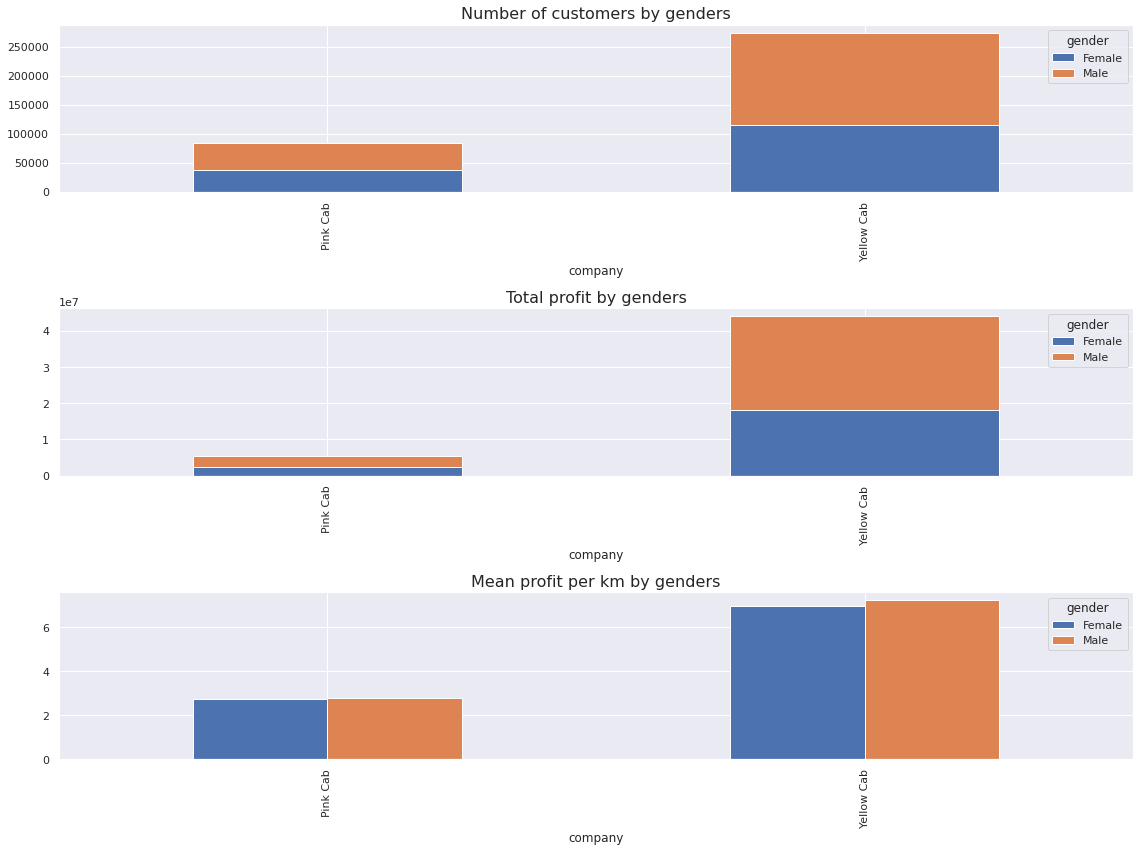

In [27]:
#create dataframe and pivot
df_gen_cit =df.groupby(['company', 'gender']).agg({'customer_id': 'count', 'profit': 'sum', 'profit_per_km':'mean'})
pivot1 = pd.pivot_table(data=df_gen_cit, index=['company'], columns=['gender'], values=['customer_id', 'profit', 'profit_per_km'])

#create figure
fig, ax = plt.subplots(3, figsize = (16,12))
pivot1.plot(ax = ax[0], y='customer_id', kind = 'bar', stacked = True)
pivot1.plot(ax = ax[1], y='profit', kind = 'bar', stacked = True)
pivot1.plot(ax = ax[2], y='profit_per_km', kind = 'bar')

ax[0].set_title('Number of customers by genders', fontsize=16)
ax[1].set_title('Total profit by genders', fontsize=16)
ax[2].set_title('Mean profit per km by genders', fontsize=16)

plt.tight_layout() 

pivot1.applymap(int)

We can see that customers-women have less share in number of customers and in total profit. Mean profit per km is equal for both genders in Pink Cab, in Yellow Cab profit_per_km for men is a bit higher. We can also confirm the graphs information by using z-test and compare means of men and women samples for profit_per_km.

In [28]:
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest

#create dataframes by gender
df_man_p = pink[pink.gender == 'Male']
df_woman_p = pink[pink.gender == 'Female']

df_man_y = yellow[yellow.gender == 'Male']
df_woman_y = yellow[yellow.gender == 'Female']

#check that sample is normally distributed. p-value < 0.05 - normally distributed
print(stats.normaltest(df_man_p.profit_per_km))
print(stats.normaltest(df_woman_p.profit_per_km))
print(stats.normaltest(df_man_y.profit_per_km))
print(stats.normaltest(df_woman_y.profit_per_km))

#check equality of mean for profit 
zScore_p, pValue_p = ztest(df_man_p['profit_per_km'], df_woman_p['profit_per_km'])
zScore_y, pValue_y = ztest(df_man_y['profit_per_km'], df_woman_y['profit_per_km'])
#p-value is less than 0.05 - accept H1 - there is a significant difference
print('Pink Cab - zscore:', zScore_p, 'p-value:', pValue_p)
print('Yellow Cab - zscore:', zScore_y, 'p-value:', pValue_y)


NormaltestResult(statistic=7690.8674634025165, pvalue=0.0)
NormaltestResult(statistic=7193.912235470766, pvalue=0.0)
NormaltestResult(statistic=14087.725907636854, pvalue=0.0)
NormaltestResult(statistic=12005.713390108263, pvalue=0.0)
Pink Cab - zscore: 2.1784673392237073 p-value: 0.029371261252986836
Yellow Cab - zscore: 12.842905603086624 p-value: 9.426877393091985e-38


According to the z-test, we can see that in Pink Cab there is also a significant difference between mean profit per km between men and women. Also, we can look at profit and mean profit by years.

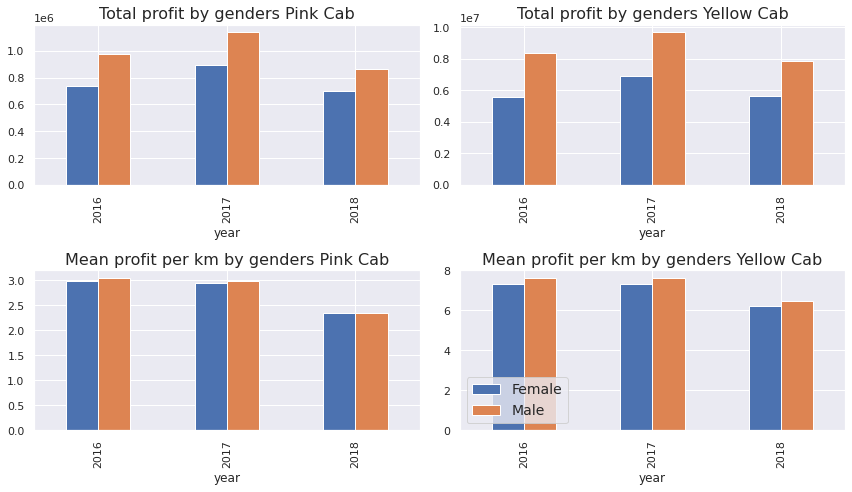

In [29]:
#create dataframes
df_gen_time = df.groupby(['year', 'company', 'gender']). agg({'profit': 'sum', 'profit_per_km':'mean'}).reset_index()
df_gen_time = df_gen_time.set_index('year') 
df_gen_time_p = df_gen_time[df_gen_time.company == 'Pink Cab']
df_gen_time_y = df_gen_time[df_gen_time.company == 'Yellow Cab']

#create pivot tables
pivot1 = pd.pivot_table(data=df_gen_time_p, index=['year'], columns=['gender'], values=['profit', 'profit_per_km'])
pivot2 = pd.pivot_table(data=df_gen_time_y, index=['year'], columns=['gender'], values=['profit', 'profit_per_km'])

#plot graphs
fig, ax = plt.subplots(2,2,figsize=(18,12))
pivot1.plot(ax=ax[0,0], y='profit', kind = 'bar', figsize = (12,7), legend=None)
pivot2.plot(ax=ax[0,1], y='profit', kind = 'bar', figsize = (12,7), legend=None)
pivot1.plot(ax=ax[1,0], y='profit_per_km', kind = 'bar', figsize = (12,7), legend=None)
pivot2.plot(ax=ax[1,1], y='profit_per_km', kind = 'bar', figsize = (12,7), legend=None)

ax[0,0].set_title('Total profit by genders Pink Cab', fontsize=16)
ax[0,1].set_title('Total profit by genders Yellow Cab', fontsize=16)
ax[1,0].set_title('Mean profit per km by genders Pink Cab', fontsize=16)
ax[1,1].set_title('Mean profit per km by genders Yellow Cab', fontsize=16)
plt.legend(loc='lower left', fontsize = 14)
plt.tight_layout()

Next, we would like to know how many customers present in different age groups, gender-wise and company-wise.

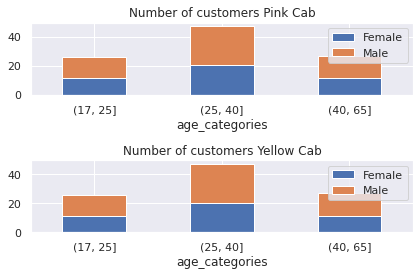

In [30]:
#create age intervals
bins = [df.age.min()-1, 25, 40, df.age.max()]
df['age_categories'] = pd.cut(df['age'], bins)

#create dataframes
df1 = df.groupby(['company','gender', 'age_categories']). agg({'customer_id': 'count'})
df1.columns = ['bin_num']
df1 = df1.reset_index(level = 0)
df_p = df1[df1['company'] == 'Pink Cab'].copy(deep=True)
df_y = df1[df1['company'] == 'Yellow Cab'].copy(deep=True)

df_p['percent_of_customers'] = (df_p['bin_num']/ df_p['bin_num'].sum()) * 100
df_y['percent_of_customers'] = (df_y['bin_num']/ df_y['bin_num'].sum()) * 100

#create pivot tables
pivot1 = pd.pivot_table(data=df_p, index=['age_categories'], columns=['gender'], values=['company', 'percent_of_customers'])
pivot2 = pd.pivot_table(data=df_y, index=['age_categories'], columns=['gender'], values=['company', 'percent_of_customers'])

#draw figures 
fig, ax = plt.subplots(2)
pivot1.plot(ax = ax[0], kind = 'bar', stacked = True, rot=0, figsize=(6,4))
pivot2.plot(ax = ax[1], kind = 'bar', stacked = True, rot=0, figsize=(6,4))
ax[0].legend(labels=['Female', 'Male'], loc = 'upper right')
ax[1].legend(labels=['Female', 'Male'], loc = 'upper right')
ax[0].set_title('Number of customers Pink Cab')
ax[1].set_title('Number of customers Yellow Cab')
plt.tight_layout()
plt.show()

We see that almost half of customers in both companies have age between 26 and 40 years. Categories 18-25 and 41-65 have equal shares. We can also check correlation between age, number of customers and profit metrics.

In [31]:
df_age = df.groupby('age').agg({'customer_id':'count', 'profit': 'sum', 'profit_per_km': 'mean'}).reset_index()
corr_prof_cust_age = df_age[['age', 'customer_id', 'profit_per_km', 'profit']].corr()
corr_prof_cust_age

,age,customer_id,profit_per_km,profit
age,1.000000,-0.873965,-0.176785,-0.878044
customer_id,-0.873965,1.000000,0.061543,0.995439
profit_per_km,-0.176785,0.061543,1.000000,0.144057
profit,-0.878044,0.995439,0.144057,1.000000


There is strong negative correlation between age and number of customers and age and total profit. Elder people use cab service less often and have a smaller contribution to total profit.

Next, we would like to check, what payment mode is more popular between different age groups.

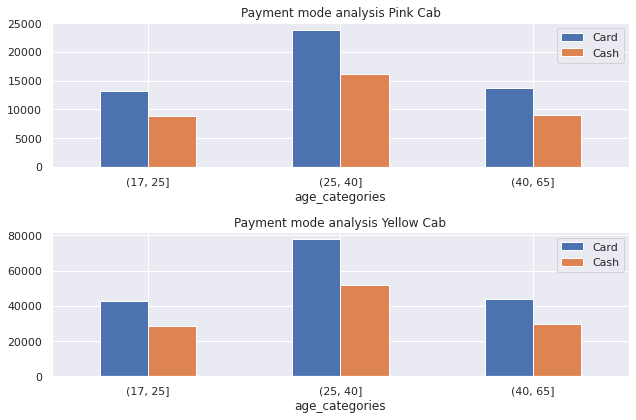

In [32]:
#create dataframes
df1 = df.groupby(['company', 'payment_mode', 'age_categories']). agg({'customer_id': 'count'})
df1.columns = ['customer_num']
df1 = df1.reset_index(level = 0)
df_p = df1[df1['company'] == 'Pink Cab'].copy(deep=True)
df_y = df1[df1['company'] == 'Yellow Cab'].copy(deep=True)

#create pivot tables
pivot1 = pd.pivot_table(data=df_p, index=['age_categories'], columns=['payment_mode'], values=['company', 'customer_num'])
pivot2 = pd.pivot_table(data=df_y, index=['age_categories'], columns=['payment_mode'], values=['company', 'customer_num'])

#draw graphs
fig, ax = plt.subplots(2)
pivot1.plot(ax = ax[0], kind = 'bar', stacked = False, rot=0, figsize=(9,6))
pivot2.plot(ax = ax[1], kind = 'bar', stacked = False, rot=0, figsize=(9,6))
ax[0].legend(labels=['Card', 'Cash'], loc = 'upper right')
ax[1].legend(labels=['Card', 'Cash'], loc = 'upper right')
ax[0].set_title('Payment mode analysis Pink Cab')
ax[1].set_title('Payment mode analysis Yellow Cab')
plt.tight_layout()
plt.show()

Across each age group and companies, card payment mode is more popular. We can confirm it by z-test.

In [33]:
#create dataframes by gender
df_cash_p = pink[pink.payment_mode == 'Cash'].groupby('customer_id').count().reset_index()
df_card_p = pink[pink.payment_mode == 'Card'].groupby('customer_id').count().reset_index()

df_cash_y = yellow[yellow.payment_mode == 'Cash'].groupby('customer_id').count().reset_index()
df_card_y = yellow[yellow.payment_mode == 'Card'].groupby('customer_id').count().reset_index()

#check that sample is normally distributed. p-value < 0.05 - normally distributed
print(stats.normaltest(df_cash_p.customer_id))
print(stats.normaltest(df_card_p.customer_id))
print(stats.normaltest(df_cash_y.customer_id))
print(stats.normaltest(df_card_y.customer_id))

#check equality of mean for profit 
zScore_p, pValue_p = ztest(df_cash_p['customer_id'], df_card_p['profit_per_km'])
zScore_y, pValue_y = ztest(df_cash_y['customer_id'], df_card_y['profit_per_km'])
#p-value is less than 0.05 - accept H1 - there is a significant difference
print('Pink Cab - zscore:', zScore_p, 'p-value:', pValue_p)
print('Yellow Cab - zscore:', zScore_y, 'p-value:', pValue_y)

NormaltestResult(statistic=4577.021643207642, pvalue=0.0)
NormaltestResult(statistic=10611.731775398564, pvalue=0.0)
NormaltestResult(statistic=29971.263744548647, pvalue=0.0)
NormaltestResult(statistic=17776.182823267394, pvalue=0.0)
Pink Cab - zscore: 188.10933864283209 p-value: 0.0
Yellow Cab - zscore: 239.48783327337128 p-value: 0.0


z-test confirms that there are significant difference in mean number of customers which pay by cash and by card in both companies.

Next, we will explore connection between income and companies performance.

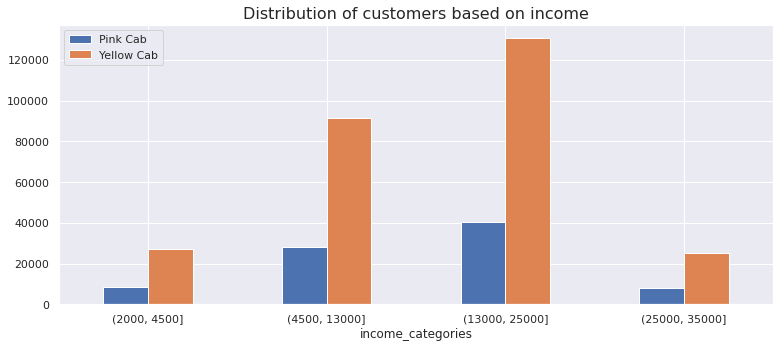

In [34]:
#bins were formed based on the categories present in the link: https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system
#create income bins
bins = [df['income_(usd/month)'].min(), 4500, 13000, 25000, df['income_(usd/month)'].max()]

#create df and pivot 
df['income_categories'] = pd.cut(df['income_(usd/month)'], bins)
df1 = df.groupby(['company', 'income_categories']). agg({'customer_id': 'count'})
df1.columns = ['bin_num']
df1 = df1.reset_index()
pivot1 = pd.pivot_table(data=df1, index=['income_categories'], columns=['company'], values=['bin_num'])

#draw plot
ax = pivot1.plot(kind = 'bar', stacked = False, rot=0, figsize=(11,5))
ax.legend(labels=['Pink Cab', 'Yellow Cab'], loc = 'upper left')
ax.set_title('Distribution of customers based on income', fontsize = 16)
plt.tight_layout()
plt.show()

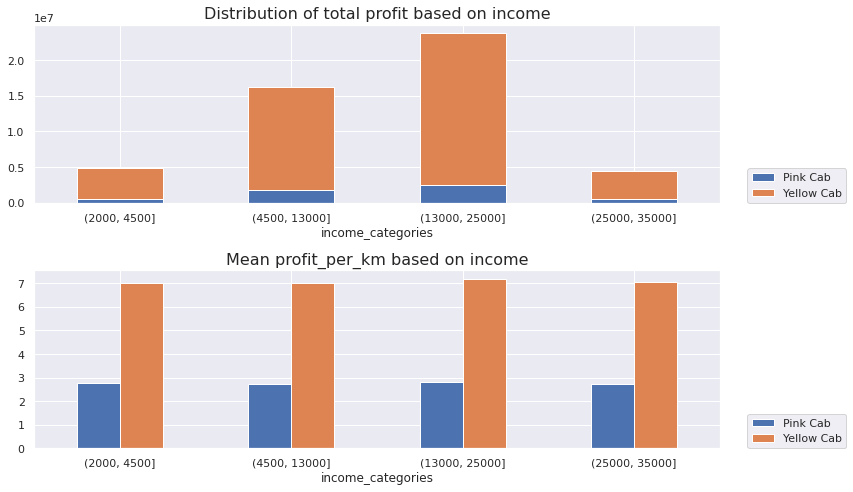

In [35]:
df1 = df.groupby(['company', 'income_categories']). agg({'profit': 'sum', 'profit_per_km': 'mean'})
df1.columns = ['bin_profit', 'profit_per_km']
df1 = df1.reset_index(level = 0)

pivot1 = pd.pivot_table(data=df1, index=['income_categories'], columns=['company'], values=['bin_profit', 'profit_per_km'])

fig, ax = plt.subplots(2)
pivot1.plot(ax = ax[0], y = 'bin_profit', kind = 'bar', stacked = True, rot=0, figsize=(12,7))
pivot1.plot(ax = ax[1], y = 'profit_per_km', kind = 'bar', rot=0, figsize=(12,7))

ax[0].legend(labels=['Pink Cab', 'Yellow Cab'], loc = (1.04,0))
ax[1].legend(labels=['Pink Cab', 'Yellow Cab'], loc = (1.04,0))
ax[0].set_title('Distribution of total profit based on income', fontsize = 16)
ax[1].set_title('Mean profit_per_km based on income', fontsize = 16)
plt.tight_layout()
plt.show()

The bigest part of total profit belongs to medium-higher income group and there's no difference in mean profit per km between income groups. 
Also we'd like to look at dynamic analysis of profit by income categories.

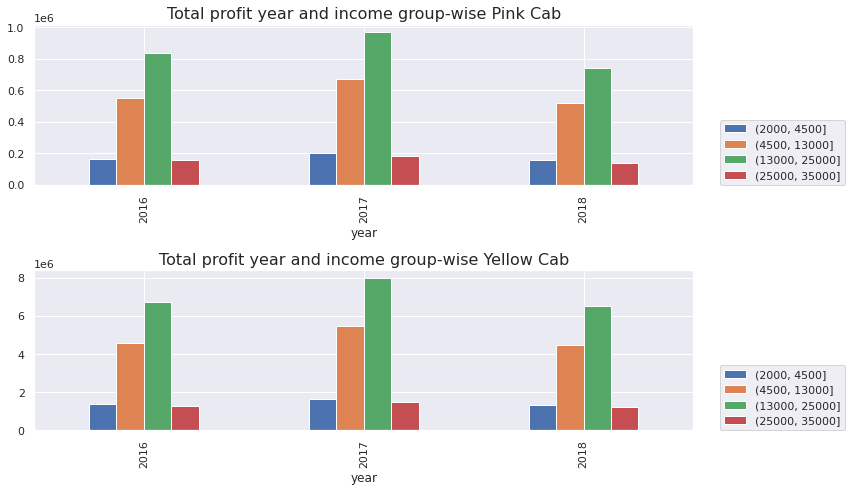

In [36]:
#create dataframe and pivot
df['income_categories'] = pd.cut(df['income_(usd/month)'], bins)
df_age_month = df.groupby(['year', 'income_categories', 'company']).agg({'profit' : 'sum'}).reset_index()
df_age_month_p = df_age_month[df_age_month.company == 'Pink Cab']
df_age_month_y = df_age_month[df_age_month.company == 'Yellow Cab']
pivot1 = pd.pivot_table(data=df_age_month_p, index=['year'], columns=['income_categories'], values=['profit'])
pivot2 = pd.pivot_table(data=df_age_month_y, index=['year'], columns=['income_categories'], values=['profit'])

#draw graph
fig, ax = plt.subplots(2)
pivot1.plot(ax = ax[0], y='profit', kind = 'bar', stacked = False, figsize = (12,7))
pivot2.plot(ax = ax[1], y='profit', kind = 'bar', stacked = False, figsize = (12,7))
ax[0].legend(loc=(1.04,0)) 
ax[1].legend(loc=(1.04,0))
ax[0].set_title('Total profit year and income group-wise Pink Cab', fontsize = 16)
ax[1].set_title('Total profit year and income group-wise Yellow Cab', fontsize = 16)
plt.tight_layout();

Distribution of income groups in time is quite stable. We can also check correlation between income and other metrics.

In [37]:
df_income = df.groupby('income_(usd/month)').agg({'customer_id':'count', 'profit': 'sum', 'profit_per_km': 'mean'}).reset_index()
corr_prof_cust_inc = df_income[['income_(usd/month)', 'customer_id', 'profit_per_km', 'profit']].corr()
corr_prof_cust_inc

,income_(usd/month),customer_id,profit_per_km,profit
income_(usd/month),1.000000,-0.111821,-0.009966,-0.065859
customer_id,-0.111821,1.000000,0.375694,0.855855
profit_per_km,-0.009966,0.375694,1.000000,0.659133
profit,-0.065859,0.855855,0.659133,1.000000


We can see that there's no strict correlation between income per month and profit metrics. There's small negative correlation with number of customers.

It'a also interesting to know how customers and profits are distributed geographically. 

Geographical analysis include:
- distribution of customers and profits across states
- profit analysis by cities

Hypothesis8 - in average more populated cities and states bring higher profit and have bigger customer base.

In [38]:
import plotly.express as px 
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#create df
df_state = df.groupby(['company', 'state']). agg({'customer_id': 'count', 'profit': 'sum', 'profit_per_km': 'mean' })
df_state = df_state.reset_index()
df_state.columns = ['company', 'state', 'Number of customers', 'Total profit',
       'Mean profit per km']
locations = [i for i in list(df.state.unique()) if i != None]

#plot figures
fig1 = px.choropleth(df_state, locations=locations*2, locationmode="USA-states", color='Number of customers', scope="usa", facet_col= 'company', title = 'Number of customers by states')
fig2 = px.choropleth(df_state, locations=locations*2, locationmode="USA-states", color='Total profit', scope="usa", facet_col= 'company', title = 'Total profit by states')
fig3 = px.choropleth(df_state, locations=locations*2, locationmode="USA-states", color='Mean profit per km', scope="usa", facet_col= 'company', title = 'Mean profit per km by states')

fig1.show()
fig2.show()
fig3.show()

We can see that NY state is the most proffitable for Yellow Cab company. Both companies have the highest profit per km in this state. For Pink Cab, maximum number of customers is in Texas state. However, profits distribution is quite equal across the states.

We can also estimate which cities are the most attractive for further development. This bubble chart displays cities based on population (size of a bubble), percentage of company customers related to number of users and mean profit per km.

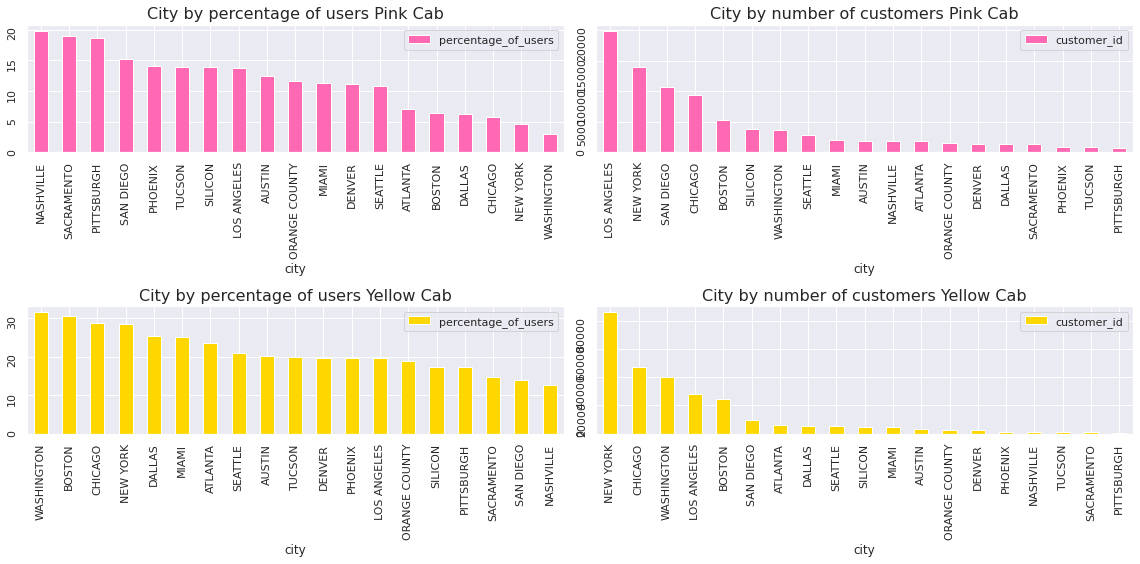

In [39]:
#create dataframes
df_cities = df.groupby(['city', 'company']).agg({'population':'mean', 'users':'mean', 'customer_id':'count', 'profit_per_km': 'mean', 'profit':'sum'}).reset_index()
df_cities['percentage_of_users'] = (df_cities.customer_id.div(df_cities.users)) * 100

#plot figures
fig = px.scatter(df_cities, x="percentage_of_users", y="profit_per_km",
	         size="population", color="city", text="city",
                 hover_name="city", log_x=True, size_max=40, facet_col='company')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=700, width = 1500,
    title_text='Potential of developing cab service in different cities'
)
fig.show()

#create dataframes
df_cities_p = df_cities[df_cities.company == 'Pink Cab']
df_cities_y = df_cities[df_cities.company == 'Yellow Cab']

#plot figures
fig, ax = plt.subplots(2,2, figsize = (16,8))
df_cities_p.sort_values('percentage_of_users', ascending = False).plot(ax = ax[0,0], kind = 'bar', x = 'city', y = 'percentage_of_users', color = 'hotpink', rot=0)
df_cities_p.sort_values('customer_id', ascending = False).plot(ax = ax[0,1], kind = 'bar', x = 'city', y = 'customer_id', color = 'hotpink', rot=0)

df_cities_y.sort_values('percentage_of_users', ascending = False).plot(ax = ax[1,0], kind = 'bar', x = 'city', y = 'percentage_of_users', color = 'gold',rot=0)
df_cities_y.sort_values('customer_id', ascending = False).plot(ax = ax[1,1], kind = 'bar', x = 'city', y = 'customer_id', color = 'gold',rot=0)

ax[0,0].tick_params(labelrotation=90)
ax[1,0].tick_params(labelrotation=90)
ax[0,1].tick_params(labelrotation=90)
ax[1,1].tick_params(labelrotation=90)

ax[0,0].set_title('City by percentage of users Pink Cab', fontsize = 16)
ax[0,1].set_title('City by number of customers Pink Cab', fontsize = 16)
ax[1,0].set_title('City by percentage of users Yellow Cab', fontsize = 16)
ax[1,1].set_title('City by number of customers Yellow Cab', fontsize = 16)

plt.tight_layout() 

We can see that New York significantly differs from the other cities due to its population and relativelly high profit per km. More attractive cities are cities that are situated closer to upper-rigth corner and have a bigger 'bubble' size.

Also there are list of the cities with comparison of customers number and share of customers in total number of cab users in the city.

We can check correlation between city population, cab users and other metrics one more time.

In [40]:
df_city = df.groupby('city').agg({'customer_id':'count', 'profit': 'sum', 'profit_per_km': 'mean', 'population': 'mean', 'users': 'mean'}).reset_index()
corr_prof_cust_city = df_city[['population', 'users', 'customer_id', 'profit_per_km', 'profit']].corr()
corr_prof_cust_city

,population,users,customer_id,profit_per_km,profit
population,1.000000,0.815582,0.802086,0.828917,0.974907
users,0.815582,1.000000,0.999006,0.530739,0.873473
customer_id,0.802086,0.999006,1.000000,0.513136,0.863166
profit_per_km,0.828917,0.530739,0.513136,1.000000,0.786497
profit,0.974907,0.873473,0.863166,0.786497,1.000000


As we saw earlier, all the features analyzed are strongly connected with number of users and population.
Also, in addition, it could be helpful to check how the mean temperature in US is connected with number of transactions and profit per km. For these purpose I downloaded data from the site NOAA - https://www.ncdc.noaa.gov/cag/statewide/time-series/30/tavg/1/12/2016-2018?base_prd=true&begbaseyear=2016&endbaseyear=2018

Hypothesis9 - there is positive relations between temperature and metrics (number of transactions, profit per km).

In [57]:
#files treatment
path = os.path.abspath('temperature_data')
import os
list_of_files = []
for item in os.listdir(path):
    if '110-tavg-' in item:
        list_of_files.append(item)

df_temp = pd.read_csv(path + '/'+list_of_files[0], skiprows=[0, 1,2,3], usecols= ['Date', 'Value'])
for file in list_of_files[1:]:
    df_month = pd.read_csv(path + '/'+file, skiprows=[0, 1,2,3], usecols= ['Date', 'Value'])
    df_temp = df_temp.append(df_month) 
df_temp['month_year'] = pd.to_datetime(df_temp.Date, format='%Y%m').dt.to_period('M')
del df_temp['Date']
df_temp.columns = ['temperature', 'month_year']
df_temperature = pd.merge(df, df_temp)

We would like to check the correlation between variables.

In [58]:
df_temper = df_temperature.groupby(['month_year']).agg({'temperature':'mean', 'profit_per_km':'mean','km_travelled':'mean', 'transaction_id': 'count', 'cost_of_trip':'mean'}).reset_index()
corr_prof_km_temp = df_temper[['temperature', 'profit_per_km', 'km_travelled', 'transaction_id']].corr()
corr_prof_km_temp

,temperature,profit_per_km,km_travelled,transaction_id
temperature,1.000000,-0.389644,-0.178865,-0.066924
profit_per_km,-0.389644,1.000000,0.070652,-0.618893
km_travelled,-0.178865,0.070652,1.000000,-0.233858
transaction_id,-0.066924,-0.618893,-0.233858,1.000000


We can see, that there is medium negative correlation between temperature and profit per km. This means that in colder days profit per km is higher. There's no correlation between temperature and number of transactions. Probably, it'a connected with a fact that we take average US temperature and it should be considered region-wisely.

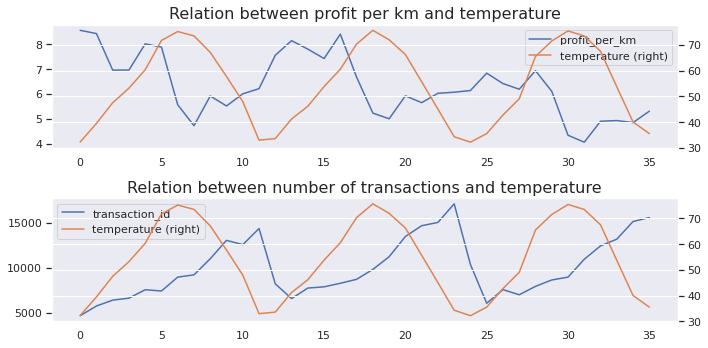

In [59]:
#plot the figure
fig, ax = plt.subplots(2)

df_temper.plot(ax = ax[0], y='profit_per_km', kind = 'line', figsize = (10,5))
df_temper.plot(ax = ax[0], y='temperature', kind = 'line', figsize = (10,5), secondary_y = True)

df_temper.plot(ax = ax[1], y='transaction_id', kind = 'line', figsize = (10,5))
df_temper.plot(ax = ax[1], y='temperature', kind = 'line', figsize = (10,5), secondary_y = True)
ax[0].set_title('Relation between profit per km and temperature', fontsize = 16)
ax[1].set_title('Relation between number of transactions and temperature', fontsize = 16)
plt.tight_layout()

Thus, several hypotheses were put forward, most of which were confirmed using graphical information and statistical tests:

- Hypothesis1 - there is seasonality in companies performance (number of transactions, number of customers, profit, profit per km).

Confirmed. There is seasonality in number of transactions and number of customers, as well as in profit and profit per km metrics.

- Hypothesis2 - there is significant difference in mean values of companies performance (number of transactions, number of customers, profit, profit per km). Concretely, mean of Yellow Cab is bigger.

Confirmed. There is significant difference between companies performance metrics. E.g., mean profit per km of Yellow Cab is 3 times higher.

- Hypothesis3 - Yellow Cab has higher customer retention (calculated as number of customers who used the service more than 5 times).

Confirmed. Yellow Cab has higher customer retention across 'more than 5' and 'more than 10' customer groups.

- Hypothesis4 - in average number of customers - women is less than number of customers-men and contribution to the company profit is also inequal, mean profit per km is less for customers-women.

Confirmed. There is significant difference between sum of total profit and number of customersbetween 2 genders. Moreover, there is a significant difference in mean profit per km between genders.

- Hypothesis5 - in average elder people use Cab service less frequently and contribution of this age segment to total profit is less.

Confirmed. There is a strong negative correlation between age and number of customers and age and total profit. Elder people use cab service less often and have a smaller contribution to total profit.

- Hypothesis6 - in average people with higher income use Cab service more often and contribution of this age segment to total profit is more.

Declined. There's no strict connection between income and profit. However, the biggest share of customers and profit belongs to high-medium segment (13000-25000 USD/month).

- Hypothesis7 - in average people use payment by cash less often.

Confirmed. Customers of both companies in all age groups prefer to pay by card more often.

- Hypothesis8 - in average more populated cities and states bring higher profit and have bigger customer base.

Confirmed. Number of customers, profit per km and total profit are connected with number of users and population.

- Hypothesis9 - there is positive relations between temperature and metrics (number of transactions, profit per km).

Partially confirmed. There's no strong connection between the metrics and temperature. However, there is medium negative correlation between temperature and profit per km. 

As for comparison between two Cab firms - Yellow Cab has higher performance in many aspects. It has higher customer and transaction number, higher customer retention, higher mean profit per km. It's true for all age, gender and income groups, as well as for all months of analyzed period. Moreover, it has wider geographic coverage. That is why, Yellow Cab is more recommended for investment.


Additional part - forecast of mean profit per km.

This part is devoted to building forecast of profit per km feature. The forecast graph is displayed at the end.

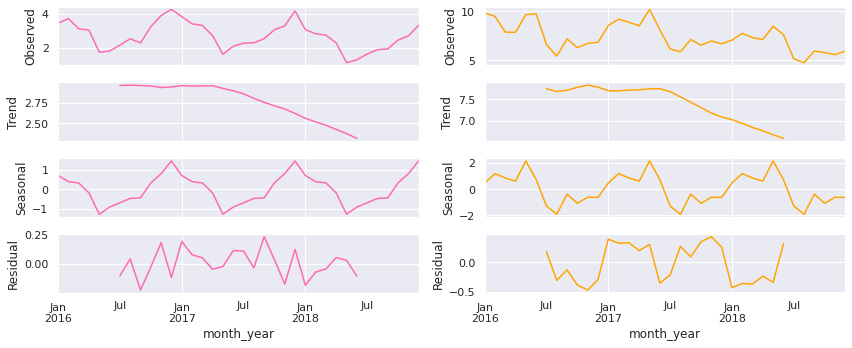

In [65]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
df_profitkm_month = df.groupby(['company', 'month_year', 'month']).agg({'profit_per_km' : 'mean'}).reset_index()
pivot = pd.pivot_table(data=df_profitkm_month, index=['month_year'], columns=['company'], values='profit_per_km')

pivot.index  = pivot.index.to_timestamp()
decompose_result_mult1 = seasonal_decompose(pivot[['Pink Cab']], model="additive")
decompose_result_mult2 = seasonal_decompose(pivot[['Yellow Cab']], model="additive")

def plotseasonal(res, axes, color):
    res.observed.plot(ax=axes[0], legend=False, color = color)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, color = color)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False, color = color)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, color = color)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(decompose_result_mult1, axes[:,0], 'hotpink')
plotseasonal(decompose_result_mult2, axes[:,1], 'orange')

plt.tight_layout()
plt.show()

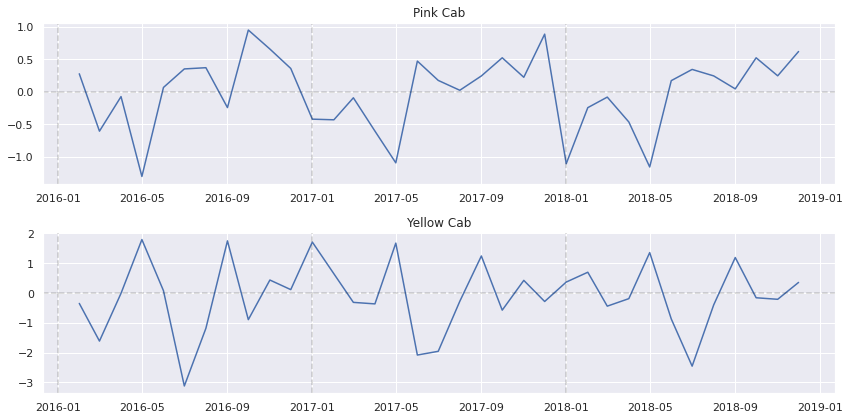

In [66]:
#remove the trend
from datetime import datetime
from datetime import timedelta

yellow = pivot[['Yellow Cab']]
pink = pivot[['Pink Cab']]

first_diff_y = yellow.diff()[1:]
first_diff_p = pink.diff()[1:]

start_date = datetime(2016,1,31)
end_date = datetime(2019,1,1)

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0].plot(first_diff_p)
ax[1].plot(first_diff_y)

ax[0].title.set_text('Pink Cab')
ax[1].title.set_text('Yellow Cab')

plt.tight_layout()
for year in range(start_date.year,end_date.year):
    ax[0].axvline(pd.to_datetime(str(year)+'-01'), color='k', linestyle='--', alpha=0.2)
    ax[1].axvline(pd.to_datetime(str(year)+'-01'), color='k', linestyle='--', alpha=0.2)

ax[0].axhline(0, color='k', linestyle='--', alpha=0.2)
ax[1].axhline(0, color='k', linestyle='--', alpha=0.2);

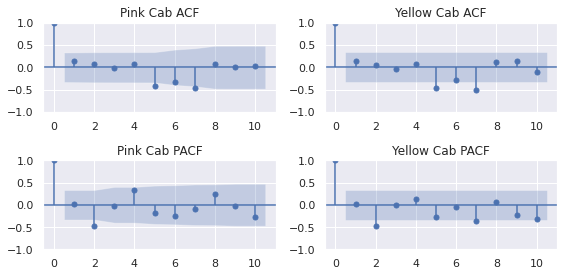

In [67]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, ax = plt.subplots(2,2,figsize=(8,4))
plot_acf(first_diff_p, lags=10, ax=ax[0,0])
plot_pacf(first_diff_p, lags=10, ax=ax[0,1], method='ywm')

plot_acf(first_diff_y, lags=10, ax=ax[1,0])
plot_pacf(first_diff_y, lags=10, ax=ax[1,1], method='ywm')
ax[0,0].title.set_text('Pink Cab ACF')
ax[0,1].title.set_text('Yellow Cab ACF')
ax[1,0].title.set_text('Pink Cab PACF')
ax[1,1].title.set_text('Yellow Cab PACF')

plt.tight_layout()
plt.show()

In [68]:
#get train and test set
train_end = datetime(2018,7,1)
test_end = datetime(2021,1,1)

train_data_p = pink[:train_end]
test_data_p = pink[train_end + timedelta(days=1):test_end]
train_data_y = yellow[:train_end]
test_data_y = yellow[train_end + timedelta(days=1):test_end]

from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order_p = (1,1,0)
my_seasonal_order_p = (1, 0, 1, 12)
my_order_y = (1,1,1)
my_seasonal_order_y = (1, 0, 1, 12)
# define model
model_p = SARIMAX(train_data_p, order=my_order_p, seasonal_order=my_seasonal_order_p)
model_y = SARIMAX(train_data_y, order=my_order_y, seasonal_order=my_seasonal_order_y)

#fit the model
model_p_fit = model_p.fit(disp=0)
model_y_fit = model_y.fit(disp=0)

#summary of the model
#print(model_p_fit.summary())
#print(model_y_fit.summary());

Mean Absolute Percent Error Pink Cab: 0.0512
Root Mean Squared Error Pink Cab: 0.1374
Mean Absolute Percent Error Yellow Cab: 0.0376
Root Mean Squared Error Yellow Cab: 0.2595


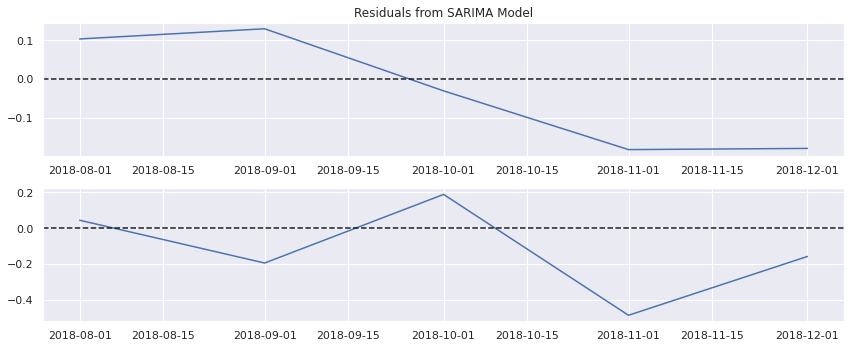

In [69]:
import numpy as np 
#get the predictions and residuals
predictions_p = model_p_fit.forecast(len(test_data_p))
predictions_p = pd.Series(predictions_p, index=test_data_p.index)
predictions_y = model_y_fit.forecast(len(test_data_y))
predictions_y = pd.Series(predictions_y, index=test_data_y.index)
test_data_p = test_data_p.squeeze(axis=1)
test_data_y = test_data_y.squeeze(axis=1)
residuals_p = test_data_p - predictions_p
residuals_y = test_data_y - predictions_y

fig, ax = plt.subplots(2,figsize=(12,5))

ax[0].plot(residuals_p)
ax[1].plot(residuals_y)

ax[0].axhline(0, linestyle='--', color='k')
ax[1].axhline(0, linestyle='--', color='k')

ax[0].title.set_text('Residuals from SARIMA Model')
plt.tight_layout()

print('Mean Absolute Percent Error Pink Cab:', round(np.mean(abs(residuals_p/test_data_p)),4))
print('Root Mean Squared Error Pink Cab:', round(np.sqrt(np.mean(residuals_p**2)),4))
print('Mean Absolute Percent Error Yellow Cab:', round(np.mean(abs(residuals_y/test_data_y)),4))
print('Root Mean Squared Error Yellow Cab:', round(np.sqrt(np.mean(residuals_y**2)),4))

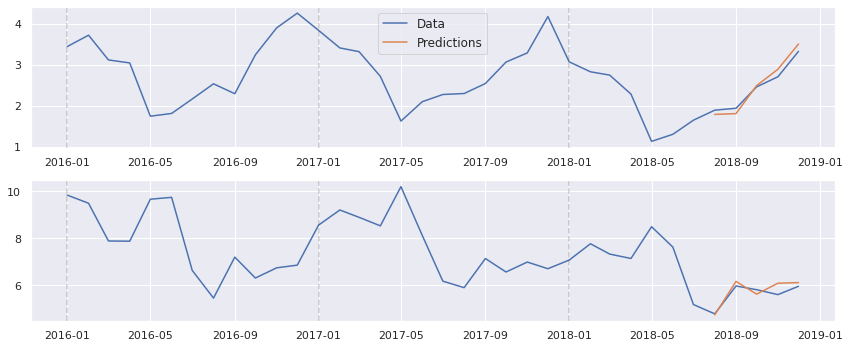

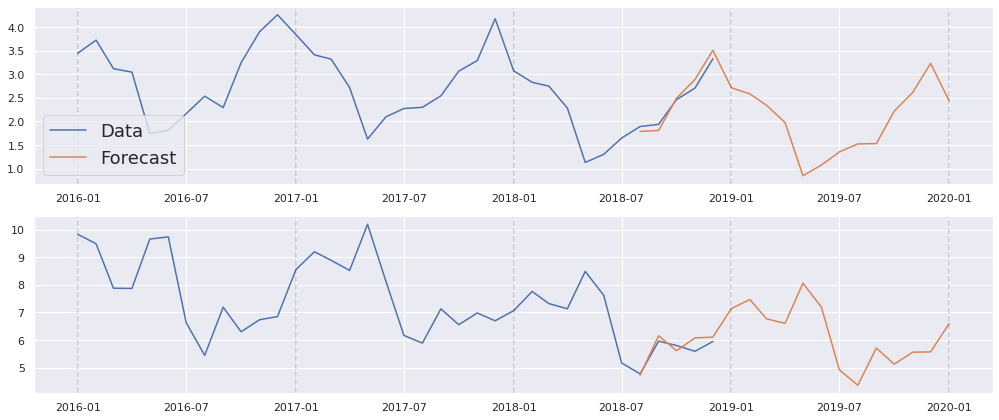

In [70]:
fig, ax = plt.subplots(2,figsize=(12,5))

ax[0].plot(pink)
ax[0].plot(predictions_p)
ax[1].plot(yellow)
ax[1].plot(predictions_y)
ax[0].legend(('Data', 'Predictions'), fontsize=12)

plt.tight_layout()
for year in range(start_date.year,end_date.year):
    ax[0].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    ax[1].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

forecast_future_p = model_p_fit.forecast(steps=18)
forecast_future_y = model_y_fit.forecast(steps=18)

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# invert the differenced forecast to something usable
history_p = [x for x in pink.values]
history_y = [x for x in yellow.values]

month = 1
for yhat_p, yhat_y in zip(forecast_future_p, forecast_future_y):
	inverted_p = inverse_difference(history_p, yhat_p, 12)
	inverted_y = inverse_difference(history_y, yhat_y, 12)
	history_p.append(inverted_p)
	history_p.append(inverted_y)
	month += 1

fig, ax = plt.subplots(2,figsize=(14,6))

ax[0].plot(pink)
ax[0].plot(forecast_future_p)
ax[1].plot(yellow)
ax[1].plot(forecast_future_y)
ax[0].legend(('Data', 'Forecast'), fontsize=18, loc = 'lower left')

plt.tight_layout()
for year in range(start_date.year,2021):
    ax[0].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    ax[1].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)